In [1]:
# Import necessary libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV


In [2]:
# Load data
df = pd.read_csv('kc_house_data.csv', encoding='ISO-8859-1')

# Display the first few rows of the dataset to inspect its structure
print(df.head())

             id             date     price  bedrooms  bathrooms  sqft_living  \
0  7.129301e+09  20141013T000000  221900.0       3.0       1.00       1180.0   
1  6.414100e+09  20141209T000000  538000.0       3.0       2.25       2570.0   
2  5.631500e+09  20150225T000000  180000.0       2.0       1.00        770.0   
3  2.487201e+09  20141209T000000  604000.0       4.0       3.00       1960.0   
4  1.954401e+09  20150218T000000  510000.0       3.0       2.00       1680.0   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0    5650.0     1.0         0.0   0.0  ...    7.0      1180.0            0.0   
1    7242.0     2.0         0.0   0.0  ...    7.0      2170.0          400.0   
2   10000.0     1.0         0.0   0.0  ...    6.0       770.0            0.0   
3    5000.0     1.0         0.0   0.0  ...    7.0      1050.0          910.0   
4    8080.0     1.0         0.0   0.0  ...    8.0      1680.0            0.0   

   yr_built  yr_renovated  zipcode    

In [3]:
# Check for missing values
print(df.isna().sum())


id               20613
date             20613
price            20613
bedrooms         20613
bathrooms        20613
sqft_living      20613
sqft_lot         20613
floors           20613
waterfront       20613
view             20613
condition        20613
grade            20613
sqft_above       20613
sqft_basement    20613
yr_built         20613
yr_renovated     20613
zipcode          20613
lat              20613
long             20613
sqft_living15    20613
sqft_lot15       20613
dtype: int64


In [4]:
# Feature engineering
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df = df.drop(['id', 'date'], axis=1)

# Drop rows where the target variable 'price' is NaN
df = df.dropna(subset=['price'])

# Separate features and target variable
X = df.drop('price', axis=1)
y = df['price']

# Impute missing values in features
imputer_X = SimpleImputer(strategy='mean')
X = imputer_X.fit_transform(X)

<Figure size 1000x1000 with 0 Axes>

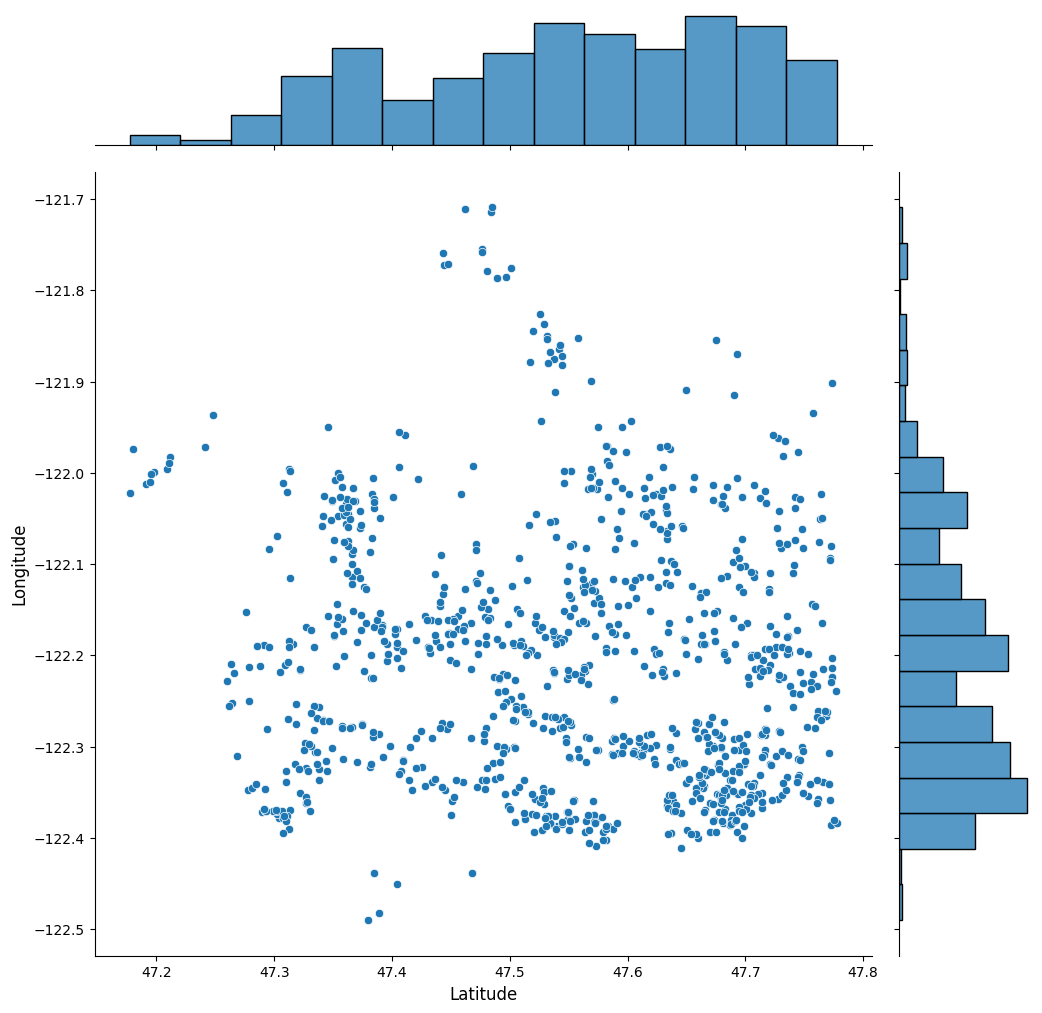

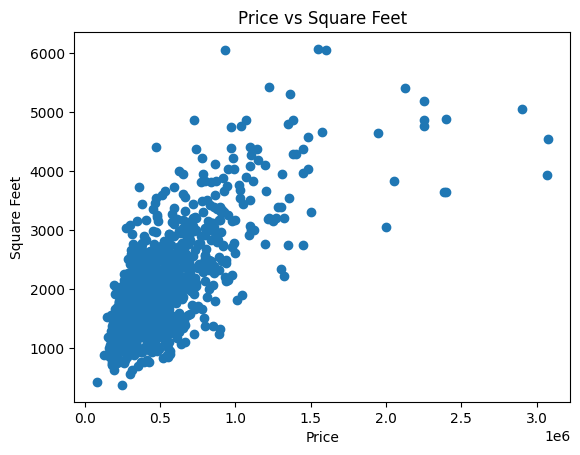

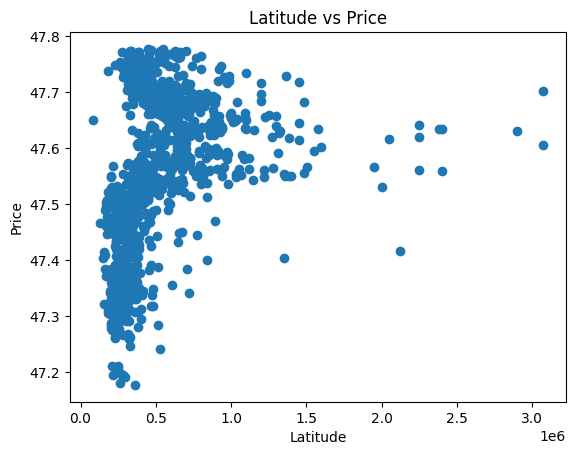

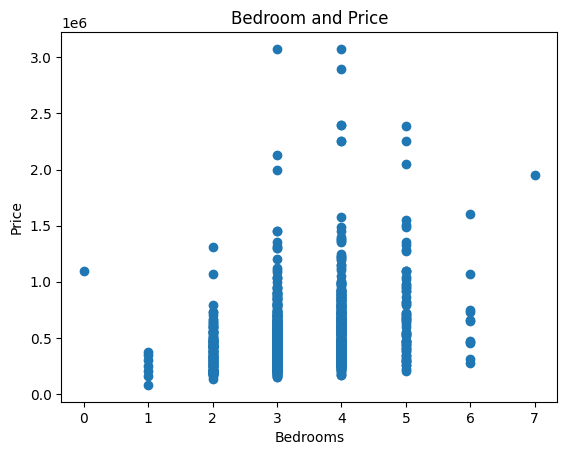

In [5]:
# Data visualization
plt.figure(figsize=(10, 10))
sns.jointplot(x=df['lat'].values, y=df['long'].values, height=10)
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
plt.show()

plt.scatter(df['price'], df['sqft_living'])
plt.title('Price vs Square Feet')
plt.xlabel('Price')
plt.ylabel('Square Feet')
plt.show()

plt.scatter(df['price'], df['lat'])
plt.title('Latitude vs Price')
plt.xlabel('Latitude')
plt.ylabel('Price')
plt.show()

plt.scatter(df['bedrooms'], df['price'])
plt.title('Bedroom and Price')
plt.xlabel('Bedrooms')
plt.ylabel('Price')
plt.show()

In [6]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Mean Squared Error (Fixed Hyperparameters): 54696472954.676735
Best parameters: {'kernel': 1**2 * RBF(length_scale=2)}
Best Model Mean Squared Error (Optimized Hyperparameters): 54696473456.99667


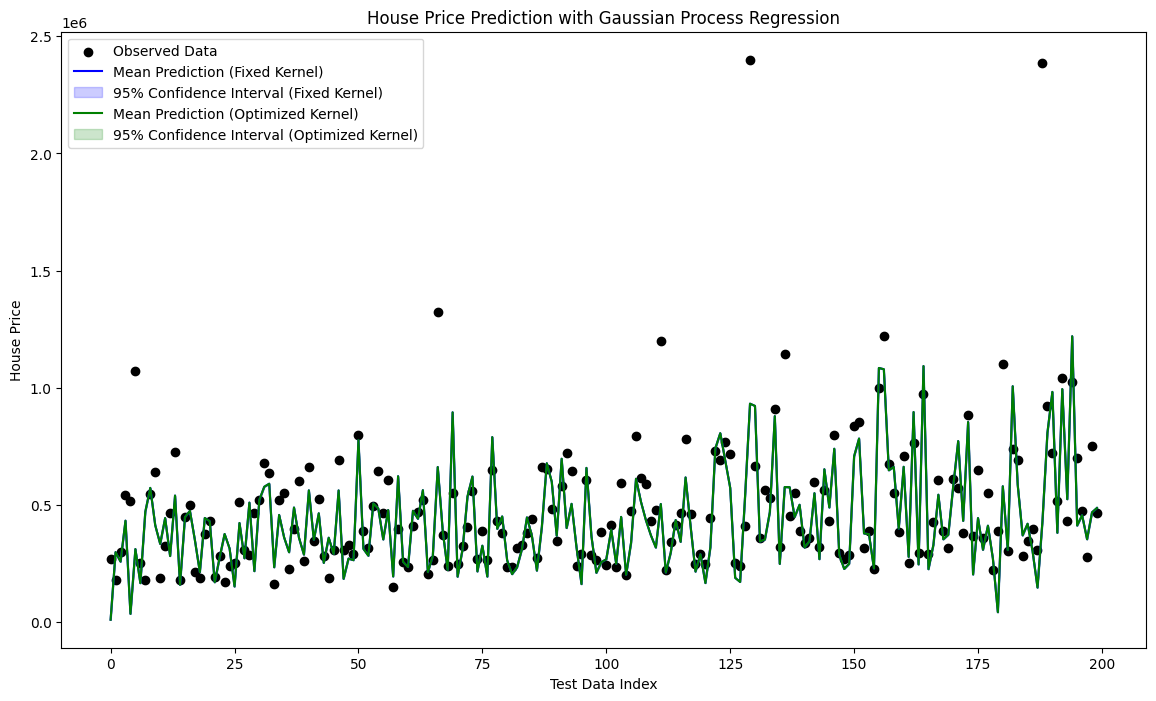

In [7]:


# Gaussian Process Regression with fixed kernel
fixed_kernel = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-2, 1e2))
gpr_fixed = GaussianProcessRegressor(kernel=fixed_kernel, n_restarts_optimizer=10, alpha=1e-2)
gpr_fixed.fit(X_train, y_train)
y_pred_fixed, y_std_fixed = gpr_fixed.predict(X_test, return_std=True)
mse_fixed = mean_squared_error(y_test, y_pred_fixed)
print(f'Mean Squared Error (Fixed Hyperparameters): {mse_fixed}')

# Hyperparameter tuning with GridSearchCV
param_grid = {
    "kernel": [C(1.0, (1e-3, 1e3)) * RBF(length_scale) for length_scale in [1.0, 1.5, 2.0]]
}
gpr_grid = GridSearchCV(GaussianProcessRegressor(n_restarts_optimizer=10, alpha=1e-2), param_grid, cv=5, scoring='neg_mean_squared_error')
gpr_grid.fit(X_train, y_train)
print(f'Best parameters: {gpr_grid.best_params_}')
best_gpr = gpr_grid.best_estimator_
y_pred_best, y_std_best = best_gpr.predict(X_test, return_std=True)
mse_best = mean_squared_error(y_test, y_pred_best)
print(f'Best Model Mean Squared Error (Optimized Hyperparameters): {mse_best}')

# Plotting predictions
sorted_indices = np.argsort(X_test[:, 0])
X_test_sorted = X_test[sorted_indices]
y_test_sorted = y_test.values[sorted_indices]
y_pred_fixed_sorted = y_pred_fixed[sorted_indices]
y_std_fixed_sorted = y_std_fixed[sorted_indices]
y_pred_best_sorted = y_pred_best[sorted_indices]
y_std_best_sorted = y_std_best[sorted_indices]

plt.figure(figsize=(14, 8))
plt.scatter(np.arange(len(y_test_sorted)), y_test_sorted, color='black', label='Observed Data')
plt.plot(np.arange(len(y_test_sorted)), y_pred_fixed_sorted, 'b-', label='Mean Prediction (Fixed Kernel)')
plt.fill_between(np.arange(len(y_test_sorted)), y_pred_fixed_sorted - 1.96 * y_std_fixed_sorted, y_pred_fixed_sorted + 1.96 * y_std_fixed_sorted, alpha=0.2, color='blue', label='95% Confidence Interval (Fixed Kernel)')
plt.plot(np.arange(len(y_test_sorted)), y_pred_best_sorted, 'g-', label='Mean Prediction (Optimized Kernel)')
plt.fill_between(np.arange(len(y_test_sorted)), y_pred_best_sorted - 1.96 * y_std_best_sorted, y_pred_best_sorted + 1.96 * y_std_best_sorted, alpha=0.2, color='green', label='95% Confidence Interval (Optimized Kernel)')
plt.legend()
plt.xlabel('Test Data Index')
plt.ylabel('House Price')
plt.title('House Price Prediction with Gaussian Process Regression')
plt.show()
